---

# <center>★ AI / ML Lesson - Tensorflow Dev ★

---

<center><img src="tf.jpg" style="width: 1000px;"/>

---

TensorFlow is an open source framework developed by Google researchers to run machine learning, deep learning and other statistical and predictive analytics workloads. Like similar platforms, it's designed to streamline the process of developing and executing advanced analytics applications for users such as data scientists, statisticians and predictive modelers.

The TensorFlow software handles data sets that are arrayed as computational nodes in graph form. The edges that connect the nodes in a graph can represent multidimensional vectors or matrices, creating what are known as tensors. Because TensorFlow programs use a data flow architecture that works with generalized intermediate results of the computations, they are especially open to very large-scale parallel processing applications, with neural networks being a common example.

The framework includes sets of both high-level and low-level APIs. Google recommends using the high-level ones when possible to simplify data pipeline development and application programming. However, knowing how to use the low-level APIs -- called TensorFlow Core -- can be valuable for experimentation and debugging of applications, the company says; it also gives users a "mental model" of the machine learning technology's inner workings, in Google's words.

TensorFlow applications can run on either conventional CPUs or higher-performance graphics processing units (GPUs), as well as Google's own tensor processing units (TPUs), which are custom devices expressly designed to speed up TensorFlow jobs. Google's first TPUs, detailed publicly in 2016, were used internally in conjunction with TensorFlow to power some of the company's applications and online services, including its RankBrain search algorithm and Street View mapping technology.

In early 2018, Google furthered its external TensorFlow efforts by making the second generation of TPUs available to Google Cloud Platform users for training and running their own machine learning models. TensorFlow-based workloads are billed on a per-second basis; the Cloud TPU service initially was launched as a beta program with only "limited quantities" of the devices available for use, according to Google.

---

### **Let us understand custom development with Tensorflow:**
1. Custom Layers
2. Custom Model
3. Custom Training

---

# <center> 1. Custom Layers

### Implementing custom layers:
The best way to implement your own layer is extending the tf.keras.Layer class and implementing:

* The __init__ method is used to initialize the object’s state. The task of constructors is to initialize(assign values) to the data members of the class when an object of class is created. The method is useful to do any initialization you want to do with your object.
* self represents the instance of a class and binds the attributes with the given arguments.
* super(), It returns a proxy/temporary object that allows us to access methods of the base class.

The __call__ method inside Model does forward computation infact comes from keras.engine.layer._Layer class. It is inherited by Model class. We want to override the inherited call method, with the new __call__ method. That is why we don't need to do a model.call(). So when we call our model instance, it's inherited __call__ method will be executed automatically, which calls our own call method. One of the central abstraction in Keras is the Layer class. A layer encapsulates both a state (the layer's "weights") and a transformation from inputs to outputs (a "call", the layer's forward pass).

In [37]:
import os

import tensorflow as tf 
from tensorflow import keras 
from tensorflow.keras import layers,Model 
from tensorflow.keras.datasets import mnist 
from tensorflow.keras.utils import plot_model 

### Dense Layer

In [38]:
class custom_dense(keras.layers.Layer):
    def __init__(self, units, input_dim):
        super().__init__()
        self.w = self.add_weight(
            name="w",
            shape=(input_dim, units),
            initializer="random_normal",
            trainable=True,
        )
        self.b = self.add_weight(
            name="b", shape=(units,), initializer="zeros", trainable=True
        )

    def call(self, inputs):
        return tf.matmul(inputs, self.w) + self.b

###  CNN Layer

In [39]:
class custom_CNN(keras.layers.Layer):
    def __init__(self, filters, kernel_size=3):
        super().__init__()
        self.conv = layers.Conv2D(filters, kernel_size, padding="same")
        self.bn = layers.BatchNormalization()

    def call(self, input_tensor, training=False):
        x = self.conv(input_tensor)
        x = self.bn(x, training=training)
        x = tf.nn.relu(x)
        return x
    
    def model(self):
        x = keras.Input()
        return keras.Model(inputs=[x], outputs=self.call(x))

### Relu activation function

In [40]:
class MyReLU(keras.layers.Layer):
    
    def __init__(self):
        super().__init__()

    def call(self, x):
        return tf.math.maximum(x, 0)

---

# <center> 2. Custom Model

Model subclassing--> Both the sequential model and functional API of Keras are useful for building models that are straightforward but they cannot be customized beyond one extent. To overcome this shortcoming Keras provides a more flexible option of Model SubClassing to build fully-customizable models. This is useful when you are researching new types of architecture from scratch.


Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_21 (InputLayer)       [(None, 28, 28, 1)]       0         
                                                                 
 custom_cnn_24 (custom_CNN)  (None, 28, 28, 32)        448       
                                                                 
 custom_cnn_25 (custom_CNN)  (None, 28, 28, 64)        18752     
                                                                 
 flatten_10 (Flatten)        (None, 50176)             0         
                                                                 
 custom_dense_18 (custom_den  (None, 64)               3211328   
 se)                                                             
                                                                 
 my_re_lu_9 (MyReLU)         (None, 64)                0         
                                                          

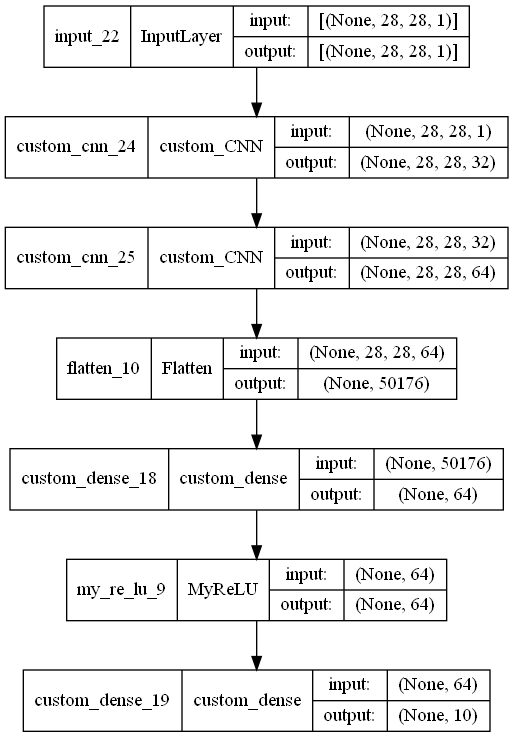

In [46]:
# Creating custom model class

class MyModel(keras.Model):  # model.fit, model.evalute, model.predict
    def __init__(self, num_classes=10):
        super().__init__()
        self.custom_CNN1 = custom_CNN(32)
        self.custom_CNN2 = custom_CNN(64)
        self.flatten = layers.Flatten()
        self.dense1 = custom_dense(64,64*28*28)
        self.dense2 = custom_dense(num_classes,64)
        self.relu = MyReLU()

    def call(self, x):
        x = self.custom_CNN2(self.custom_CNN1(x))
        x = self.flatten(x)
        x = self.relu(self.dense1(x))
        return self.dense2(x)
    
    def model(self):
        x = keras.Input(shape=(28,28,1))
        return Model(inputs=[x],outputs=self.call(x))
    
sub_model = MyModel()

sub_model.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=["accuracy"])

sub_model.model().summary()

plot_model(sub_model.model(), to_file='sub_model.png',show_shapes=True)

You can pass a Dataset instance directly to the methods fit(), evaluate(), and predict():

---

# <center> 3. Custom Training

#### Gradient Tape

tf.GradientTape --> Record operations for automatic differentiation.

> To differentiate automatically, TensorFlow needs to remember what operations happen in what order during the forward pass. Then, during the backward pass, TensorFlow traverses this list of operations in reverse order to compute gradients.


* With eager execution enabled, Tensorflow will calculate the values of tensors as they occur in your code. 
* This means that it won't precompute a static graph for which inputs are fed in through placeholders. 
* This means to back propagate errors, you have to keep track of the gradients of your computation and then apply these gradients to an optimiser.

* If you have a custom layer, you can define exactly how the operations occur within that layer, including the gradients that are computed and also calculating the amount of loss that is accumulated.

* So Gradient tape will just give you direct access to the individual gradients that are in the layer.

> Once you've recorded some operations, use GradientTape.gradient(target, sources) to calculate the gradient of some target (often a loss) relative to some source (often the model's variables)

In [42]:
# Custom Training class

class Custom_fit(keras.Model):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def compile(self, optimizer, loss, metric):
        super(Custom_fit, self).compile()
        self.optimizer = optimizer
        self.loss = loss
        self.metric = metric

    def train_step(self,data):
        # Unpack the data
        x, y = data
        with tf.GradientTape() as tape:
            # Compute predictions
            y_pred = self.model(x, training=True)
            # Calculating loss
            loss = self.loss(y, y_pred)

        # Tracking gradients
        training_vars = self.trainable_variables
        gradients = tape.gradient(loss, training_vars)

        #Update optimizer & metrics
        self.optimizer.apply_gradients(zip(gradients, training_vars))
        self.metric.update_state(y, y_pred)
        return {"Train_loss for Custom_train": loss, "Train_accuracy for Custom_train": self.metric.result()}

    def test_step(self, data):
        # Unpack the data
        x, y = data
        # Compute predictions
        y_pred = self.model(x, training=False)
        # Calculating loss
        loss = self.loss(y, y_pred)
        #Update optimizer & metrics
        self.metric.update_state(y, y_pred)
        return {"Test_loss for Custom_test": loss, "Test_accuracy for Custom_test": self.metric.result()}

In [48]:
# Preparing Data

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.reshape(-1, 28, 28, 1).astype("float32") / 255.0
x_test = x_test.reshape(-1, 28, 28, 1).astype("float32") / 255.0

AUTOTUNE = tf.data.experimental.AUTOTUNE

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = (train_dataset.shuffle(buffer_size=len(y_train)).batch(32,drop_remainder=True).prefetch(buffer_size=AUTOTUNE))

test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_dataset = (test_dataset.batch(32,drop_remainder=False).prefetch(buffer_size=AUTOTUNE))

# Custom training

cus_train = Custom_fit(cus_model)
cus_train.compile(
    optimizer=keras.optimizers.Adam(learning_rate=3e-4),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metric = keras.metrics.SparseCategoricalAccuracy(name="accuracy")
)

cus_train.fit(train_dataset, batch_size=32, epochs=2)
cus_train.evaluate(test_dataset, batch_size=32)

Epoch 1/2
 175/1875 [=>............................] - ETA: 2:22 - Train_loss for Custom_train: 0.5170 - Train_accuracy for Custom_train: 0.7363

KeyboardInterrupt: 

---